## Exotic grass mapping project: Script to generate likelihoods of Johnsongrass presence based on summer NDVI data

In [31]:
import numpy as np
import datetime as dt
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import os
import dask
import rasterio
import time
import geopandas as gpd
from rasterio import features
from rasterio import transform
import urllib.request
from dask.distributed import Client
from dask.distributed import wait, progress
import holoviews as hv
import geoviews as gv
import hvplot.xarray
import hvplot.pandas
import shapely
from urllib.request import urlopen
from zipfile import ZipFile
import requests
from io import BytesIO
import shapefile
from shapely.geometry import shape
from numba import jit
from urllib.error import HTTPError
from itertools import product
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [32]:
landsat_proj = 'epsg:32613'

In [33]:
#fire up local dask cluster
client = Client()

C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [34]:
client

Client Scheduler: tcp://127.0.0.1:60562 Dashboard: http://127.0.0.1:60565/status,Cluster Workers: 4 Cores: 8 Memory: 34.02 GB


### Access data from AWS
Note that it is also possible to load this once and then save to a zar file so you can reload it quickly later on, however this was not possible on my computer at first pass, and additionally the loading of data from AWS only takes a few minutes.

In [35]:
def multiple_WRS(loc):
    """Given multiple paths or rows, return CMR syntax for this query"""
    locs = ''
    for i, val in enumerate(loc):
        if i == 0:
            locs += str(val)
        else:
            locs += ',' + str(val)
    return locs

In [36]:
def query_cmr_landsat(collection='Landsat_8_OLI_TIRS_C1', tier='T1', paths=[30,31], rows=[39,40]):
    
    """Query NASA CMR for Collection1, Tier1 Landsat scenes from a specific path(s) and row(s)."""
    
    def multiple_WRS(loc):
        """Given multiple paths or rows, return CMR syntax for this query"""
        locs = ''
        for i, val in enumerate(loc):
            if i == 0:
                locs += str(val)
            else:
                locs += ',' + str(val)
        return locs
    
    data = [f'short_name={collection}',
            f'page_size=2000',
            f'attribute[]=string,CollectionCategory,{tier}',
            f'attribute[]=int,WRSPath,{multiple_WRS(paths)}',
            f'attribute[]=int,WRSRow,{multiple_WRS(rows)}',
           ]
    
    query = 'https://cmr.earthdata.nasa.gov/search/granules.json?' + '&'.join(data)
    
    r = requests.get(query, timeout=100)
    print(r.url)
    
    df = pd.DataFrame(r.json()['feed']['entry'])
                      
    return df

In [37]:
def make_AWS_archive(pids, bands):
    "Turn list of product_ids into pandas dataframe for analysis"
    path = lambda pid: pid.split('_')[2][:3]
    row = lambda pid: pid.split('_')[2][-3:]
    baseurl = f'https://landsat-pds.s3.amazonaws.com/c1/L8'
    
    dates = [pd.to_datetime(x.split('_')[3]) for x in pids]
    df = pd.DataFrame(dict(product_ids=pids, date=dates))
    
    for band in bands:
        df[band] = [f'{baseurl}/{path(x)}/{row(x)}/{x}/{x}_{band}.TIF' for x in pids]
    
    return df

In [38]:
def make_AWS_archive_meta(pids):
    "Turn list of product_ids into pandas dataframe for analysis"
    path = lambda pid: pid.split('_')[2][:3]
    row = lambda pid: pid.split('_')[2][-3:]
    baseurl = f'https://landsat-pds.s3.amazonaws.com/c1/L8'
    
    dates = [pd.to_datetime(x.split('_')[3]) for x in pids]
    df = pd.DataFrame(dict(product_ids=pids, date=dates))
    
    df['meta_url'] = [f'{baseurl}/{path(x)}/{row(x)}/{x}/{x}_MTL.txt' for x in pids]
    
    return df

In [39]:
def metadata_key(meta_url, key):
    with urlopen(meta_url) as f:
        try:
            return [line.decode('utf-8').replace('\n', '').split(' = ')[1] for line in f if key in line][0]
        except TypeError:
            print('TypeError: Key must be in bytes (b\'key\')')
        except IndexError:
            print("IndexError: Key is not in metadata file")

In [40]:
@jit(nopython=False, parallel=True)
def toa(img, m, a, sun_e):
    # Top Of Atmosphere (TOA) reflectance corrections
    return (img*m+a)/np.sin(np.deg2rad(sun_e))

In [41]:
def create_multiband_dataset(row, bands=['B4', 'B5'], chunks={'band': 1, 'x': 2048, 'y': 2048}):
    '''A function to load multiple landsat bands into an xarray dataset '''
    ''' If meta_url is supplied, apply TOA correction before continuing'''
    #Each image is a dataset containing both band4 and band5
    datasets = []
    for band in bands:
        url = row[band]
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        da = da.where(da != 0, other = np.nan)
        if 'meta_url' in row.keys():
            band_m = 2.0000E-05
            band_a = -0.1 
            sun_e = float(metadata_key(row['meta_url'], b'SUN_ELEVATION'))
            da = toa(da, band_m, band_a, sun_e)
            cld_cvr = float(metadata_key(row['meta_url'], b'CLOUD_COVER'))
        else:
            cld_cvr = np.nan
        ds = da.to_dataset(name=band)
        datasets.append(ds)
    DS = xr.merge(datasets)
    DS['Cloud_Cover'] = cld_cvr
    
    return DS

In [42]:
df = query_cmr_landsat(paths=[30], rows=[40])
pids = df.title.tolist()
df = make_AWS_archive(pids, ['B4', 'B5'])
df_meta = make_AWS_archive_meta(pids)
df = df.merge(df_meta[['meta_url', 'product_ids']], how = 'left', on = 'product_ids')
int_dates = df.date.dt.strftime('%m%d').astype(int)
df_summer = df[int_dates.between(525,707)] #select from last week of may to first week of june (5/25 to 7/7)

https://cmr.earthdata.nasa.gov/search/granules.json?short_name=Landsat_8_OLI_TIRS_C1&page_size=2000&attribute%5B%5D=string,CollectionCategory,T1&attribute%5B%5D=int,WRSPath,30&attribute%5B%5D=int,WRSRow,40


In [43]:
s = time.time()
datasets = []
for i,row in df_summer.iterrows():
    try:
        print(i, 'loading...', row.date)
        ds = create_multiband_dataset(row)
        datasets.append(ds)
    except Exception as e:
        print('ERROR loading, skipping acquisition!')
        print(e)
print(f"Total time is {time.time() - s} seconds")

4 loading... 2013-06-01 00:00:00
5 loading... 2013-06-17 00:00:00
6 loading... 2013-07-03 00:00:00
25 loading... 2014-06-04 00:00:00
26 loading... 2014-06-20 00:00:00
27 loading... 2014-07-06 00:00:00
48 loading... 2015-06-07 00:00:00
49 loading... 2015-06-23 00:00:00
70 loading... 2016-06-09 00:00:00
71 loading... 2016-06-25 00:00:00
91 loading... 2017-05-27 00:00:00
92 loading... 2017-06-12 00:00:00
93 loading... 2017-06-28 00:00:00
114 loading... 2018-05-30 00:00:00
115 loading... 2018-06-15 00:00:00
116 loading... 2018-07-01 00:00:00
136 loading... 2019-06-02 00:00:00
137 loading... 2019-06-18 00:00:00
138 loading... 2019-07-04 00:00:00
Total time is 43.38770866394043 seconds


In [44]:
DS = xr.concat(datasets, dim = pd.DatetimeIndex(df_summer.date.tolist()[:len(datasets)], name = 'time'))
DS = DS.rename({'x': 'lon', 'y': 'lat'})

In [45]:
bibe_url = "https://services1.arcgis.com/fBc8EJBxQRMcHlei/arcgis/rest/services/NPS_Park_Boundaries/FeatureServer/0/query?where=UPPER(PARKNAME)%20like%20'%25BIG%20BEND%25'&outFields=*&outSR=4326&f=json"
#grasses_url = 'https://services1.arcgis.com/fBc8EJBxQRMcHlei/arcgis/rest/services/BIBE_CollectorMap2_WFL1/FeatureServer/4/query?where=OBJECTID+%3E%3D0&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=Lehmanns_Cover%2C+Johnsongrass_Cover%2C+Buffelgrass_Cover%2C+Shape__Area%2C+Notes+&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pjson&token=5FdC50OLOtj3md9KEWMcmKkeuX9_fMDd90cYXf-flCEn2wDe2cW1MWskwuiMIzi2DzRIETjG_5TBWSQBbeOtSE7jQj9V-o447I8Gwe4VG2p3dudlRB3lhRUap39oBydAhUvbhYEiYCPGWqEFlVz1DzttydGDeHke1F5ykKzOJ0A7H1h36OU-_L6s103pf6Eaav1NHvfsPDPoK7mYss6PXs-knaPdtS8mW6NfxuP7-6c.'
bibe = gpd.read_file(bibe_url, driver = 'ESRIJSON').to_crs({'init': landsat_proj})
bnds = bibe.total_bounds
bnds1 = [bnds[0], bnds[2],bnds[1], bnds[3]] #change order for plotting

#Eliminate parts of images that are always outside of BIBE boundaries (reduce size of dataset)
DS = DS.where((DS.lat > bnds[1]) & (DS.lat < bnds[3])
               & (DS.lon > bnds[0]) & (DS.lon < bnds[2]), drop = True)

#Add new variable for NDVI
DS['NDVI'] = (DS['B5'] - DS['B4'])/(DS['B5'] + DS['B4'])

C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [181]:
#Calculate affine transformation of DS
latmin, latmax = float(DS.coords['lat'].min()), float(DS.coords['lat'].max())
lonmin, lonmax = float(DS.coords['lon'].min()), float(DS.coords['lon'].max())
DS_dims = (DS.dims['lat'], DS.dims['lon'])
transf = transform.from_bounds(lonmin, latmin, lonmax, latmax, 
                               DS_dims[1] - 1, DS_dims[0] - 1) #width, height are 1 less than columns, rows

### Establishing conditions for Johnsongrass (note: these can be altered as necessary, especially as new data comes in)

Time period: Last week of May to first week of June

**1a. (Restrictive)**: NDVI >= 0.4 at least once during time period (based on mean of Johnsongrass data during that time)

**1b. (Less restrictive)**: NDVI >= 0.28 at least once during time period, based on mean minus 1 standard deviation

**2\.** NDVI >= 0.28 during the entire time period, based on mean minus 1 standard deviation

**3a. (More restrictive)** Increase in NDVI over time period is at least 0.1 between two *consecutive* satellite images

**3b. (Less restrictive)** Difference between maximum and minimum NDVI over time period is at least 0.1

In [54]:
def at_least_threshold(xa, val):
    """Returns pixels where the threshold condition is met AT LEAST ONCE during the
    time period of interest (i.e., in at least one image).
    Inputs: xa is the xarray dataset with the dates and variable of interest, 
    and it should be indexed with time as the first dimension. I.e., DS_yy.NDVI
    val is the threshold value, for example, a pixel must be >= 0.4 in the Johnsongrass case.
    """
    arr = False
    for a in xa:
        img = a.where(a >= val).values #keep only pixels >= val (Note that this can be altered to >, <=, etc.)
        mask = ~np.isnan(img) #convert to binary
        arr = np.logical_or(arr, mask) #Find OR intersection of existing output, new img output
    return arr

In [55]:
def always_threshold(xa, val):
    """Returns pixels where the threshold condition is ALWAYS met during the
    time period of interest (i.e., in at least one image).
    Inputs: xa is the xarray dataset with the dates and variable of interest, 
    and it should be indexed with time as the first dimension. I.e., DS_yy.NDVI
    val is the threshold value, for example, a pixel must be >= 0.28 in the Johnsongrass case.
    """
    arr = True
    for a in xa:
        img = a.where(a >= val).values #keep only pixels >= val (Note that this can be altered to >, <=, etc.)
        mask = ~np.isnan(img) #convert to binary
        arr = np.logical_and(arr, mask) #Find AND intersection of existing output, new img output
    return arr

In [50]:
yy = '2017'
DS_yy = DS.sel(time = slice(f'{yy}-05-25', f'{yy}-07-07'))

In [238]:
#Look at cloud cover values and remove any images that may have too much cloud cover, by using isel (integer select).
#For example - 
print(DS_yy.Cloud_Cover.values)
DS_yy = DS_yy.isel(time = [0,1]) #Choosing first two of three dates in the image to disregard 51.49% cloud cover
#for last date in 2017

[[[ 0.06  0.06  0.06 ...  0.06  0.06  0.06]
  [ 0.06  0.06  0.06 ...  0.06  0.06  0.06]
  [ 0.06  0.06  0.06 ...  0.06  0.06  0.06]
  ...
  [ 0.06  0.06  0.06 ...  0.06  0.06  0.06]
  [ 0.06  0.06  0.06 ...  0.06  0.06  0.06]
  [ 0.06  0.06  0.06 ...  0.06  0.06  0.06]]

 [[12.25 12.25 12.25 ... 12.25 12.25 12.25]
  [12.25 12.25 12.25 ... 12.25 12.25 12.25]
  [12.25 12.25 12.25 ... 12.25 12.25 12.25]
  ...
  [12.25 12.25 12.25 ... 12.25 12.25 12.25]
  [12.25 12.25 12.25 ... 12.25 12.25 12.25]
  [12.25 12.25 12.25 ... 12.25 12.25 12.25]]

 [[51.49 51.49 51.49 ... 51.49 51.49 51.49]
  [51.49 51.49 51.49 ... 51.49 51.49 51.49]
  [51.49 51.49 51.49 ... 51.49 51.49 51.49]
  ...
  [51.49 51.49 51.49 ... 51.49 51.49 51.49]
  [51.49 51.49 51.49 ... 51.49 51.49 51.49]
  [51.49 51.49 51.49 ... 51.49 51.49 51.49]]]


In [56]:
#Condition 1a: NDVI >= 0.4 at least once during time period
arr1a = at_least_threshold(DS_yy.NDVI, 0.4)

#Condition 1b: NDVI >= 0.28 at all times during time period
arr1b = always_threshold(DS_yy.NDVI, 0.28)

In [24]:
#To get the most restrictive combination of two maps -- boolean AND, use
arr1c = np.logical_and(arr1b, arr1a)

#To get less restrictive combination -- boolean OR, i.e. just one pixel must have value 1 from an image
arr1c = np.logical_and(arr1b, arr1a)

In [171]:
#Combining data from multiple years
arr_years = True
for yy in ['2016', '2017', '2018']:
    DS_yy = DS.sel(time = slice(f'{yy}-05-25', f'{yy}-07-07'))
    #Generate map for one year
    arr1a = at_least_threshold(DS_yy.NDVI, 0.4)
    #Take intersection of pixels in past years
    arr_years = np.logical_and(arr_years, arr1a)

C:\Users\kabbott\AppData\Local\ESRI\conda\envs\jupyter_gis\lib\site-packages\geopandas\plotting.py:295: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


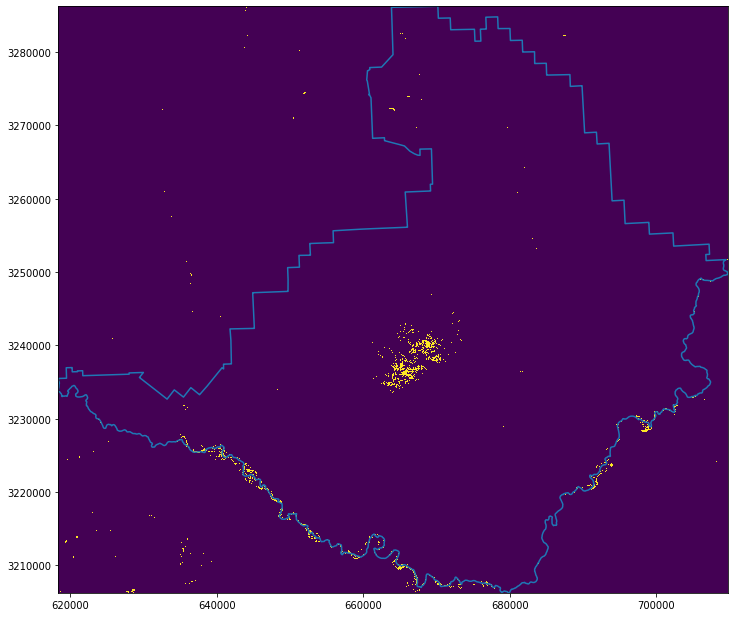

In [232]:
f, ax = plt.subplots(figsize = (12,12))
ax.imshow(np.flipud(arr_years), extent=list(bnds1))
ax = bibe.geometry.boundary.plot(axes=ax)
#plt.savefig('NDVI_2017_cond1a.png', dpi = 300)

In [33]:
### write code to save output to geotiff

In [230]:
def xarray_to_raster(xa, dst_filename, proj):
    """Converts the given xarray.DataArray object to a raster output file
    using rasterio.
    Arguments:
     - `xa`: The xarray.DataArray to convert
     - `dst_filename`: the filename to store the output GeoTIFF file in
     - 'proj': Projection as a WKT string, see cell below for example
    Notes:
    Converts the given xarray.DataArray to a GeoTIFF output file using gdal.
    
    driver = gdal.GetDriverByName('GTiff')
    """

    xa = xa.load()
    height = xa.shape[0]
    width = xa.shape[1]
    band_indices = 1
    x_min = xa['lon'].values.min()
    y_max = xa['lat'].values.max()
    pixel_size = 30
    xa_arr = np.flipud(xa.values)

    dataset = driver.Create(dst_filename, width, height, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform((x_min, pixel_size, 0,y_max, 0, -pixel_size))  
    dataset.SetProjection(proj)
    dataset.GetRasterBand(1).WriteArray(xa_arr)
    dataset.FlushCache()  # Write to disk.

In [190]:
#Create generic dataframe with the variable you want to save (i.e., here it's arr1a)
proj = 'PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],AUTHORITY["EPSG","32613"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
da = xr.DataArray(arr1a, coords = {'lat': DS1.lat, 'lon': DS1.lon}, dims = {'lat': DS1.lat, 'lon': DS1.lon}, name = 'binary_mask')

In [231]:
#Save to GeoTIFF
xarray_to_raster(da, '../images/2017_arr1a.tif', proj)